Nous allons refaire la classification de famille de protéines comme dans le TME précédente, mais avec un jeu de données plus grand. Le but est de comparer les arbres de décision et les "support vector Machine" et vérifier quel est le plus performant.

1. Commencer pour charger et préparer le jeu de données, puis le diviser en training et test, et le normaliser. Le fichier de données contient deux familles de protéines :
[PF01534](https://www.ebi.ac.uk/interpro/entry/pfam/PF01534/) et [PF05462](https://www.ebi.ac.uk/interpro/entry/pfam/PF05462/). Vous pouvez générer les même features de le TME précédent à l'aide du package protlearn.

In [47]:
import pandas as pd

dataFile = 'trainFull.csv'
# Read the csv file

df = pd.read_csv(dataFile)
Xseqs = df['Sequence'].values
Y = (df['family'].values == 'PF01534').astype(int)

In [48]:
!pip install protlearn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [49]:
from protlearn.features import ngram

X, _ = ngram(list(Xseqs), n=2)

In [50]:
print(X.shape)
print(Y.shape)

(10311, 400)
(10311,)


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

trainX, testX, trainY, testY = train_test_split(X, Y, random_state=5, test_size=0.2)
scaler = MinMaxScaler()

2. Entraîner de la meilleure façon possible (en choisissant les hyper paramètres les plus adaptés)  deux modèles de ML : DT et  SVM. Varier au moins deux parameter de chaque algorithme.

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

dt_grid = GridSearchCV(DecisionTreeClassifier(), { 'criterion': ['entropy', 'gini'], 'min_samples_split': [2, 3, 4] }, cv=5) # , scoring=cross_val_score
dt_pipeline = make_pipeline(scaler, dt_grid)
dt_pipeline.fit(trainX, trainY)

print('Params', dt_grid.best_params_)
print('Training score', dt_pipeline.score(trainX, trainY))
print('Test score', dt_pipeline.score(testX, testY))

Params {'criterion': 'entropy', 'min_samples_split': 2}
Training score 1.0
Test score 0.98691226369365


In [53]:
from sklearn.svm import SVC

svm_grid = GridSearchCV(SVC(), { 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'tol': [0.001, 0.002] }, cv=5)
svm_pipeline = make_pipeline(scaler, svm_grid)
svm_pipeline.fit(trainX, trainY)

print('Params', svm_grid.best_params_)
print('Training score', svm_pipeline.score(trainX, trainY))
print('Test score', svm_pipeline.score(testX, testY))

Params {'kernel': 'poly', 'tol': 0.001}
Training score 1.0
Test score 0.9961221522055259


3. Pour les arbres de décision affiché l'arbre? Et répondez aux question:


*   Quel node sépare le mieux les deux classes?
*   Combien de niveaux possède l'arbre?
*   Et combien de feuilles?

In [54]:
from sklearn import tree

In [58]:
print('Noeud avec la plus grand entropie :', dt_grid.best_estimator_.tree_.impurity.argmax())
print('Niveaux de l\'arbre :', dt_grid.best_estimator_.get_depth() + 1)
print('Feuilles de l\'arbre : ', dt_grid.best_estimator_.get_n_leaves())

Noeud avec la plus grand entropie : 61
Niveaux de l'arbre : 10
Feuilles de l'arbre :  50


[Text(0.5, 0.8333333333333334, 'x[38] <= 0.097\nentropy = 0.587\nsamples = 8248\nvalue = [1164, 7084]'),
 Text(0.25, 0.5, 'x[385] <= 0.072\nentropy = 0.144\nsamples = 7145\nvalue = [146, 6999]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'x[361] <= 0.065\nentropy = 0.392\nsamples = 1103\nvalue = [1018, 85]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

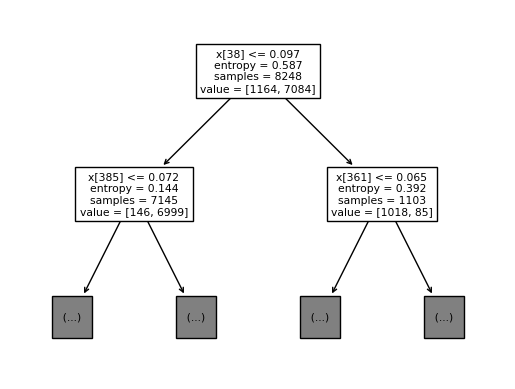

In [56]:
tree.plot_tree(dt_grid.best_estimator_, max_depth=1)

4. Comparer les performances de deux modeles à travers les ROC et les AUC.

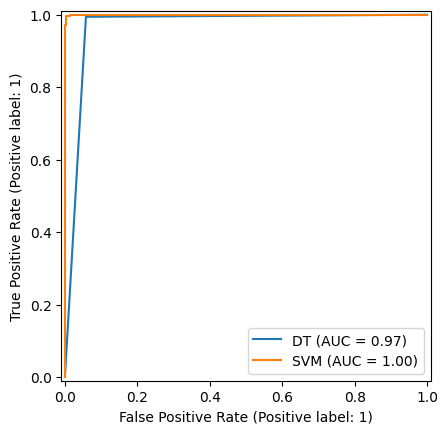

In [57]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(dt_pipeline, testX, testY, ax=ax, name='DT')
RocCurveDisplay.from_estimator(svm_pipeline, testX, testY, ax=ax, name='SVM')

5. À quelle conclusion arriviez-vous ?

Les deux modèles sont très bons, le SVM est le meilleur.